# Machine learning with the Open Data Cube  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
['s2a_msil2a']()
* **Special requirements:** A shapefile of labelled data in shapefile format is required to use this notebook.
An example dataset is provided.
* **Prerequisites:** A basic understanding of supervised learning techniques is required. 
[Introduction to statistical learning](https://doi.org/10.1007/978-1-4614-7138-7) is a useful resource to begin with - it can be downloaded for free [here](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf). 
The [Scikit-learn](https://scikit-learn.org/stable/supervised_learning.html) documentation provides information on the available models and their parameters.


## Description

This notebook demonstrates a potential workflow using functions from the [deafrica_classificationtools](../Scripts/deafrica_classificationtools.py) script to implement a supervised learning landcover classifier within the [ODC (Open Data Cube)](https://www.opendatacube.org/) framework. The user draws geometry in an `ipyleaflet map` which will be used to create the `training data`. 
> Users who have their own training data can skip this step, and directly import there own shapefile. This example predicts a single class, e.g. urban / non-urban

Where the user has their own training data, for larger model training and prediction implementations this notebook can be adapted into a Python file and run in a distributed fashion.

The notebook demonstrates how to:

1. Draw geometry in an Ipyleaflet map and export to a shapefile.
2. Train a simple decision tree model and adjust parameters. 
3. Predict landcover using trained model on new data.
4. Evaluate the output of the classification using quantitative metrics and qualitative tools.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import shapely
import rasterio
import datacube
import matplotlib
import pydotplus
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from io import StringIO
from sklearn import tree
from sklearn import model_selection
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, GeoJSON
from sklearn.metrics import accuracy_score
from IPython.display import Image
from datacube.utils import geometry
from datacube.helpers import write_geotiff

sys.path.append('../Scripts')
from deafrica_classificationtools import predict_xr 
from deafrica_classificationtools import get_training_data_for_shp
from deafrica_plotting import map_shapefile
from deafrica_datahandling import load_ard



### Connect to the datacube

Connect to the datacube so we can access DEAfrica data.

In [2]:
dc = datacube.Datacube(app='Machine_learning_with_ODC')

### Add a map and draw polygons

For this example, drawing at least four polygons will demonstrate how this notebook functions. 

For building an urban / non-urban classifier. Draw two polygons in the urban area in the east of the satellite image, a two in the agricultural and forested areas.

Keep the regions small and in close proximity will keep the loading times down later in the notebook.

In [30]:
# Center near Kumasi in Ghana
center = (6.7, -1.8)

# 
m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=11) #crs='EPSG3857')

draw_control = DrawControl()

# Button to draw polygon
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 1.0
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": False
}

# Create an empty feature collection
feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

# Define function to append features as they are drawn into feature collection
def handle_draw(self, action, geo_json):
    """Do something with the GeoJSON when it's drawn on the map"""    
    feature_collection['features'].append(geo_json)

# Apply the function 'handle_draw' when something is drawn
draw_control.on_draw(handle_draw)

# Add buttons to map
m.add_control(draw_control)

m

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

The features drawn in the map are now stored in a GeoJSON called 'feature_collection'

### Edit the GeoJSON 
The class must be numerical

In [31]:
# Loop through and add class to properties
for i in range(len(feature_collection['features'])):
    if i<2:
        feature_collection['features'][i]['properties']['class'] = 1
        # Change colour for display
        feature_collection['features'][i]['properties']['style']['fillColor'] = '#44c75a'
    else:
        feature_collection['features'][i]['properties']['class'] = 2
        # Change colour for display
        feature_collection['features'][i]['properties']['style']['fillColor'] = '#f5b83d'

In [32]:
# Add edited feature to map to check
geo_json = GeoJSON(data=feature_collection)

m2 = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=11, crs='EPSG3857')
m2.add_layer(geo_json)
m2

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

### Convert GeoJSON to geopandas dataframe and preview

The shapefile should contain a column with class labels (e.g. `class` below).
These labels will be used to train our model.

In [33]:
input_data = gpd.GeoDataFrame.from_features(feature_collection['features'])
input_data

geometry  \
0  POLYGON ((-2.07137 6.77911, -2.03086 6.79479, ...   
1  POLYGON ((-2.04734 6.68364, -2.02331 6.65909, ...   
2  POLYGON ((-1.88392 6.68296, -1.85851 6.66795, ...   
3  POLYGON ((-1.62093 6.73069, -1.60377 6.70887, ...   

                                               style  class  
0  {'stroke': True, 'color': '#6be5c3', 'weight':...      1  
1  {'stroke': True, 'color': '#6be5c3', 'weight':...      1  
2  {'stroke': True, 'color': '#6be5c3', 'weight':...      2  
3  {'stroke': True, 'color': '#6be5c3', 'weight':...      2

You might wish to save your polygons for later use

In [34]:
# Save gdf as shapefile
input_data.to_file('../test2/test2.shp',driver='ESRI Shapefile')

### Analysis parameters
* `path`: The path to the input shapefile
* `field`: This is the name of column in your shapefile attribute table that contains the class labels
* `product`: The name of the product to extract
* `date`: The date you wish to extract data for, typically the same date the labels were created
* `output_crs`: This is the projection the data should be displayed in
* `feature_stats`: This is an option to calculate the mean of the values within the feature. 

In [35]:
field = 'class'
product = 's2a_msil2a'
date = '12-01-2018'
crs = 'EPSG:3857'
output_crs = 'EPSG:3857'
feature_stats = None # none selects all the pixels underlying the polygon

### Prepare polygon data
- Iplyleaflet defaults to projecting in EPSG:3857 but the coordinates are in EPSG:4326
- The GeoJSON produced by Ipyleaflet does not have an associated crs, therefore we need to set the crs


In [36]:
input_data.crs = 'EPSG:4326'
input_data = input_data.to_crs({'init': 'EPSG:3857'})
input_data

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


geometry  \
0  POLYGON ((-230584.188 756413.654, -226074.412 ...   
1  POLYGON ((-227908.958 745712.436, -225233.616 ...   
2  POLYGON ((-209716.904 745635.997, -206888.721 ...   
3  POLYGON ((-180441.547 750986.672, -178530.637 ...   

                                               style  class  
0  {'stroke': True, 'color': '#6be5c3', 'weight':...      1  
1  {'stroke': True, 'color': '#6be5c3', 'weight':...      1  
2  {'stroke': True, 'color': '#6be5c3', 'weight':...      2  
3  {'stroke': True, 'color': '#6be5c3', 'weight':...      2

## Extract training data using a shapefile

To train our model, we need to obtain satellite data that corresponds with the labelled input data locations above. 
The function below takes our shapefile containing class labels and extracts the specified product within these areas into a single array.

> **The following cell can take several minutes to run.** The class labels will be contained in the first column of the output array.

In [37]:
# Empty list which we will populate with data
out = []

# Call the extraction function
column_names = get_training_data_for_shp(geometry=input_data, 
                                         out=out,
                                         product=product,
                                         time=('2018-01-12','2018-02-01'),
                                         crs=crs,
                                         output_crs=output_crs,
                                         measurements=['blue','green','red','red_edge_1','red_edge_2','red_edge_3','nir_1','nir_2','swir_1','swir_2'],
                                         resolution=(-10,10),
                                         field=field,
                                         calc_indices=None,
                                         feature_stats=feature_stats)


Loading data...
Rasterizing features and extracting data...


In [38]:
# Stack the extracted training data for each feature into a single array
model_input = np.vstack(out)
print(f'\nOutput training data has shape {model_input.shape}')


Output training data has shape (217278, 11)


## Preprocessing

`scitkit-learn` models cannot accept training data with `NaNs` ("not a number"). 
This preprocessing step removes any potential rows in the training array with `NaNs`.

In [39]:
# Remove any potential nans
model_input = model_input[~np.isnan(model_input).any(axis=1)]
print("Cleaned input shape:", model_input.shape)

Cleaned input shape: (217278, 11)


Our training data has multiple classes in it.
However, we are only trying to predict one class (i.e. class label 111, _Cultivated Terrestrial Vegetated_) with this model. 
We therefore remove other classes from our training data by setting the label value for all other classes to 0.

These entries provide counter-examples to help the model distinguish the landcover classes from each other.

In [40]:
# Modify the input training data for single class labels
model_input[:,0] = np.where(model_input[:,0] == 1, 1, 0)

So that we can access the accuracy of our classification, we split our data into training and testing data. 
80% is used for training with 20% held back for testing.
When splitting our data, we stratify the training data by the distributions of class membership.
This sampling method leads to a similar distribution of class membership in the training data.

In [41]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(model_input, 
                                                           stratify=model_input[:, 0],
                                                           train_size=0.8, 
                                                           random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (173822, 11)
Test shape: (43456, 11)


## Model preparation

This section automatically creates a list of varaible names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue']`)

In [42]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [column_names.index(var_name) for var_name in model_variables]

A **decision tree model** is chosen as it is one of the simplest supervised machine learning models we can implement. 

Its strengths are its explainability and cheap computational cost.

Parameter tuning can be conducted in the model initialisation below - details on how the different parameters will affect the model are [here](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use).

In [43]:
# Initialise model
model = tree.DecisionTreeClassifier()

## Train model

The model is fitted / trained using the prepared training data. 
The fitting process uses the decision tree approach to create a generalised representation of reality based on the training data. 
This fitted / trained model can then be used to predict which class new data belongs to.

In [44]:
# Train model
model.fit(model_train[:, model_col_indices], model_train[:, 0])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Analyse results

### Feature importance

The decision tree classifier allows us to inspect the feature importance of each input variable.
Feature importance represents the relative contribution of each variable in predicting the desired landcover class. 
When summed, the importance of all variables should add up to 1.0.

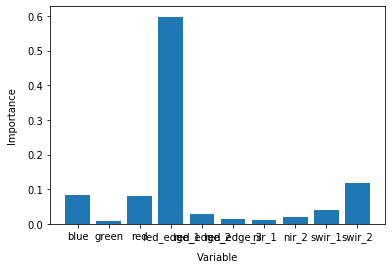

In [45]:
# This shows the feature importance of the input features for predicting the class labels provided
plt.bar(x=model_variables, height=model.feature_importances_)
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10);

This decision tree representation visualises the trained model. 
Here we can see that the model decides which landcover class to assign based on the value of the important variables in the plot above.

The **gini** value shown in the tree represents the decrease in node impurity.
This can also be understood as how heterogeneous the labels are (small values indicating better results). 
This metric is used by the decision tree to determine how to split the data into smaller groups.

This step can take a long time if using `feature_stats = None`

If the graph is small double-click to enlarge it. Double-click again to return to initial size.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.110724 to fit



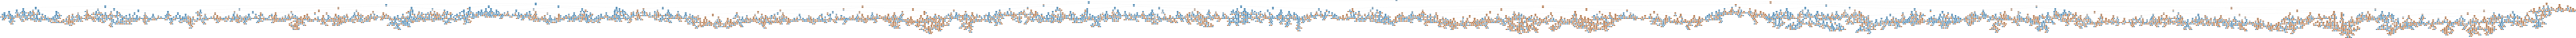

In [46]:
# Prepare a dictionary of class names
class_names = {1: 'Forest',
               0: 'Not Forest'}

# Get list of unique classes in model
class_codes = np.unique(model_train[:, 0])
class_names_in_model = [class_names[k] for k in class_codes]

# Plot decision tree
dot_data = StringIO()
tree.export_graphviz(model, 
                     out_file=dot_data, 
                     feature_names=model_variables, 
                     class_names=class_names_in_model,
                     filled=True, 
                     rounded=True,
                     special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph = Image(graph.create_png())
graph

### Accuracy

We can use the 20% sample of test data we partitioned earlier to test the accuracy of the trained model on this new, "unseen" data.

An accuracy value of 1.0 indicates that the model was able to correctly predict 100% of the classes in the test data.

In [47]:
predictions = model.predict(model_test[:, model_col_indices])
accuracy_score(predictions, model_test[:, 0])

0.9684278350515464

## Prediction

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 

The trained model can technically be used to classify any dataset or product with the same bands as the data originally used to train the data.
However, it is typically highly advisable to classify data from the same product that the data was originally trained on (e.g. `'ls8_nbart_geomedian_annual'` below).


In [48]:
# Get extent from input shapefile 
xmin, ymin, xmax, ymax = input_data.unary_union.bounds

# Define products
products = ['s2a_msil2a']

# Specify the parameters to pass to the load query
query = {
    "x": (xmin, xmax),#lons,
    "y": (ymin, ymax),#lats,
    "time": ('2018-01-12'),
    "measurements":['blue','green','red','red_edge_1','red_edge_2','red_edge_3','nir_1','nir_2','swir_1','swir_2'],
    "crs":crs,
    "output_crs": output_crs,
    "resolution": (-10, 10),
    "group_by": "solar_day"
}

# Load the data
ds = load_ard(dc, products=products, **query)#.to_crs({'init':output_crs})

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2a_msil2a
Applying pixel quality/cloud mask
Loading 1 time steps


In [49]:
# Predict landcover using the trained model
predicted = predict_xr(model, ds, progress=True)

## Plotting

To qualitatively evaluate how well the classification performed, we can plot the classifed/predicted data next to our input satellite imagery.

> **Note:** The output below is unlikely to be optimal the first time the classification is run.
The model training process is one of experimentation and assumption checking that occurs in an iterative cycle - you may need to revisit the steps above and make changes to model parameters or input training data until you achieve a satisfactory result.

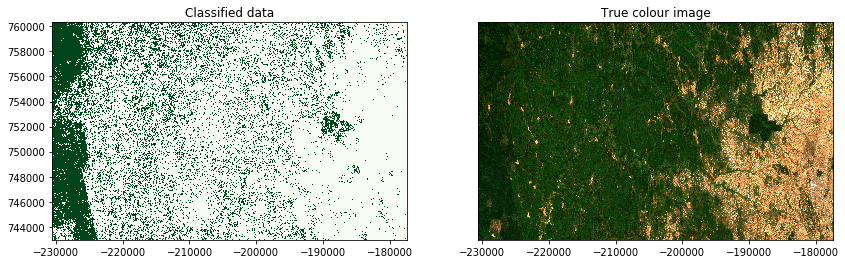

In [50]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot classified image
predicted.plot(ax=axes[0], 
               cmap='Greens', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
(ds[['red', 'green', 'blue']]
 .squeeze('time')
 .to_array()
 .plot.imshow(ax=axes[1], robust=True, add_labels=False))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified data')
axes[1].set_title('True colour image');

## Exporting classification
We can now export the predicted landcover out to a GeoTIFF `.tif` file. 
This file can be loaded into GIS software (e.g. QGIS, ArcMap) to be inspected more closely.

In [ ]:
# Write the predicted data out to a GeoTIFF
predicted = predicted.to_dataset(name="predicted")
predicted = predicted.isel(time=0)
predicted.attrs['crs'] = geometry.CRS(output_crs)
write_geotiff('predicted.tif', predicted)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)